# Intro to Python Acceleration and CSV Analysis

## Introduction
This notebook serves as an introduction to Python for a mechanical engineer looking to plot and analyze some acceleration data in a CSV file. Being a Colab, this tool can freely be used without installing anything.

For more information on making the swith to Python see [enDAQ's blog, Why and How to Get Started in Python for a MATLAB User](https://blog.endaq.com/why-and-how-to-get-started-in-python-for-a-matlab-user).

This is part of our webinar series on Python for Mechanical Engineers:

1. **Get Started with Python**
   * [Watch Recording of This](https://info.endaq.com/why-mechanical-engineers-should-use-python-webinar)
2. [Introduction to Numpy & Pandas for Data Analysis](https://colab.research.google.com/drive/1O-VwAdRoSlcrineAk0Jkd_fcw7mFGHa4#scrollTo=ce97q1ZcBiwj)
3. [Introduction to Plotly for Plotting Data](https://colab.research.google.com/drive/1pag2pKQQW5amWgRykAH8uMAPqHA2yUfU)
4. [Introduction of the enDAQ Library](https://colab.research.google.com/drive/1WAtQ8JJC_ny0fki7eUABACMA-isZzKB6)

## Import Data File
We will assume that the first column is time in seconds. Some example files are provided or you can load your own.

### Example Files
Here are some example datasets you can use to do some initial testing. If you have uploaded your own data, you'll want to comment this out or not run it!

In [ ]:
filenames = ['https://info.endaq.com/hubfs/data/surgical-instrument.csv',
             'https://info.endaq.com/hubfs/data/blushift.csv',
             'https://info.endaq.com/hubfs/Plots/bearing_data.csv', #used in this dataset: https://blog.endaq.com/top-vibration-metrics-to-monitor-how-to-calculate-them
             'https://info.endaq.com/hubfs/data/Motorcycle-Car-Crash.csv', #used in this blog: https://blog.endaq.com/shock-analysis-response-spectrum-srs-pseudo-velocity-severity
             'https://info.endaq.com/hubfs/data/Calibration-Shake.csv',
             'https://info.endaq.com/hubfs/data/Mining-Hammer.csv'] #largest dataset
filename = filenames[4]

In [ ]:
filenames[4]

'https://info.endaq.com/hubfs/data/Calibration-Shake.csv'

## Install & Import Libraries

First we'll install all libraries we'll need, then import them. 

Note that if running this locally you'll only need to install one time, then subsequent runs can just do the import. But colab and anaconda will contain all the libraries we'll need anyways so the install isn't necessary. Here is how the install would be done though:

```
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install plotly
!pip install scipy
```

You can always check which libraries you have installed by doing:

```
!pip freeze
```

We do need to upgrade plotly though to work in Colab

In [ ]:
!pip install --upgrade plotly

Now we'll import our libraries we'll use later.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as xp
import plotly.io as pio; pio.renderers.default = "iframe"
from scipy import signal

## Load the CSV, Analyze & Plot
We'll load the data into pandas, display it, do some very basic analysis, and plot the time history in a few ways.

### Load the CSV File and Prepare
Remember we are expecting the first column to be time and will set it as the index. This is loading a CSV file, but Pandas supports a lot of other file formats, see: [Pandas Input/Output](https://pandas.pydata.org/docs/reference/io.html).

If you must/need to use .MAT files, scipy can read these: [scipy.io.loadmat](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html)

In [ ]:
df = pd.read_csv(filename) #load the data
df = df.set_index(df.columns[0]) #set the first column as the index
df

,"""X (2000g)""","""Y (2000g)""","""Z (2000g)"""
Time,,,
0.004394,-0.122072,-0.122072,-0.061036
0.004594,-0.061036,0.488289,-0.366217
0.004794,0.183108,0.122072,-0.061036
0.004994,0.122072,-0.122072,-0.122072
0.005194,0.122072,0.122072,-0.244144
...,...,...,...
27.691064,-0.427253,-0.152590,-0.671397
27.691264,-0.122072,-0.335698,-0.305180
27.691464,-0.183108,-0.152590,-0.122072


### Basic Analysis
Once in a Pandas dataframe, doing some basic analysis is SUPER easy as shown. Here's a [link to the docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html) for the .max() function, but notice the many others readily available.

The peak will be applied after first finding the absolute value to ensure we don't ignore large negative values. 

$$peak=\max(\left | a \right |)$$

Then the RMS is a simple square root of the mean of all the values squared. 

$$rms = \sqrt{\left(\frac{1}{n}\right)\sum_{i=1}^{n}(a_{i})^{2}}$$

The crest factor is equal to the peak divided by the RMS.
$$crest = \frac{peak}{rms}$$

In [ ]:
abs_max = df.abs().max() #maximum of the absolute values, the peak
std = df.std() #standard deviation (equivalent to the AC coupled RMS value)
crest_factor = abs_max/std #crest factor (peak / RMS)

stats = pd.concat([abs_max, #combine the stats into one table
                   std,
                   crest_factor],
                  axis=1)
stats.columns = ['Peak Acceleration (g)','RMS (g)','Crest Factor'] #set the headers of the table
stats

,Peak Acceleration (g),RMS (g),Crest Factor
"""X (2000g)""",1.709010,0.249129,6.859939
"""Y (2000g)""",1.647974,0.279338,5.899566
"""Z (2000g)""",8.850233,2.687501,3.293109


## Plot Full Time Series
You can create a plot very simply once you have a dataframe by just doing:
~~~
df.plot()
~~~
Here we show how to manipulate this plot a bit with axes labels in Matplotlib which has a very similar interface to MATLAB. There are a lot of [pretty well documented examples on matplotlib's docs site](https://matplotlib.org/stable/gallery/index.html) (but their docs are confusing to navigate).

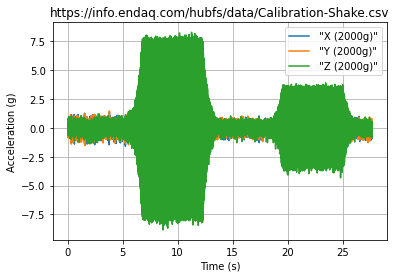

In [ ]:
fig, ax = plt.subplots() #create an empty plot

df.plot(ax=ax) #use the dataframe to add plot data, tell it to add to the already created axes

ax.set(xlabel='Time (s)',
       ylabel='Acceleration (g)',
       title=filename)
ax.grid() #turn on gridlines

fig.savefig('full-time-history.png')
plt.show()

## Plot with Plotly
Matplotlib may be familiar, but Plotly offers much more interactivity directly in a browser. They also have really [good documentation with a ton of examples online](https://plotly.com/python/).

The trouble is that plotting too many data points may be sluggish. I've long maintained that plotting 10s of thousands of data points isn't very useful anyways, you just get a shaded mess. 

So here we'll plot:

- The moving peak value
- The moving RMS
- The time history around the peak

### Moving Peak
This takes advantage of Pandas [rolling() function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html).

In [ ]:
n_steps = 100 #number of points to plot
n = int(df.shape[0]/n_steps) #number of data points to use in windowing
df_rolling_peak = df.abs().rolling(n).max().iloc[::n] #finds the absolute value of every datapoint, then does a rolling maximum of the defined window size, then subsamples every nth point

df_rolling_peak

,"""X (2000g)""","""Y (2000g)""","""Z (2000g)"""
Time,,,
0.004394,NaN,NaN,NaN
0.281203,0.976577,1.159686,0.976577
0.558025,1.159686,1.403830,1.068132
0.834870,1.403830,1.159686,1.129168
1.111689,1.220722,1.281758,1.220722
...,...,...,...
26.576863,1.159686,1.037613,0.793469
26.853655,0.976577,1.037613,0.854505
27.130463,1.068132,1.068132,0.946059


In [ ]:
fig = xp.line(df_rolling_peak)
fig.update_layout(
    title="Rolling Peak",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (g)",
)
fig.show()
fig.write_html('rolling_peak.html',full_html=False,include_plotlyjs='cdn')


### Moving RMS
Now we'll plot the rolling RMS using the standard deviation. Notice that these rolling value plots make it much easier to compare the datasets than by trying to plot all values which result in a shaded mess.

Also in this example I'm showing how easy it is to [change the theme of the plotly figure, see their documentation](https://plotly.com/python/templates/) for more examples and information. You can also make custom themes.

In [ ]:
df_rolling_rms = df.rolling(n).std().iloc[::n] #does a rolling standard deviation of the defined window size, then subsamples every nth point

fig = xp.line(df_rolling_rms)
fig.update_layout(
    title="Rolling RMS",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (g)",
    template="plotly_dark"
)
fig.show()
fig.write_html('rolling_rms.html',full_html=False,include_plotlyjs='cdn')

### Time History Around Peak
Now let's find the time that had the maximum value and display the time history around that.

In [ ]:
df.abs().max(axis=1).idxmax()

8.659936

In [ ]:
peak_time = df.abs().max(axis=1).idxmax() #get the time at which the peak value occurs
d_t = (df.index[-1]-df.index[0])/(len(df.index)-1) #find the average time step
fs = 1/d_t #find the sampling rate

num = 1000 / 2 #total number of datapoints to plot (divide by 2 because it will be two sided)
df_peak = df[peak_time - num / fs : peak_time + num / fs ] #segment the dataframe to be around that peak value

fig = xp.line(df_peak)
fig.update_layout(
    title="Time History around Peak",
    xaxis_title="Time (s)",
    yaxis_title="Acceleration (g)",
    template="plotly_white"
)
fig.show()
fig.write_html('time_history_peak.html',full_html=False,include_plotlyjs='cdn')


## PSD
Now using SciPy we can easily compute and plot a PSD using a custom function we'll make to ease the interface to [SciPy's Welch function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html). This is very similar to [MATLAB's version](https://www.mathworks.com/help/signal/ref/pwelch.html).

In [ ]:
def get_psd(df, bin_width=1.0, window="hann"):
    d_t = (df.index[-1]-df.index[0])/(len(df.index)-1)
    fs = 1/d_t
    f, psd = signal.welch(
        df.values, fs=fs, nperseg= int(fs / bin_width), window=window, axis=0
    )

    df_psd = pd.DataFrame(psd, columns=df.columns)
    df_psd["Frequency (Hz)"] = f
    df_psd = df_psd.set_index("Frequency (Hz)")
    return df_psd


In [ ]:
df_psd = get_psd(df,bin_width=4) #compute a PSD with a 1 Hz bin width
df_psd.to_csv('psd.csv') #save to a CSV file
df_psd

,"""X (2000g)""","""Y (2000g)""","""Z (2000g)"""
Frequency (Hz),,,
0.000000,0.000048,0.000049,0.000072
4.000048,0.000294,0.000276,0.000332
8.000095,0.000256,0.000254,0.000287
12.000143,0.000189,0.000206,0.000230
16.000191,0.000170,0.000156,0.000193
...,...,...,...
2484.029606,0.000007,0.000006,0.000007
2488.029654,0.000007,0.000006,0.000006
2492.029702,0.000007,0.000007,0.000007


In [ ]:
fig = xp.line(df_psd)
fig.update_layout(
    title="Power Spectral Density (PSD)",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g^2/Hz)",
    xaxis_type="log",
    yaxis_type="log"
)
fig.show()
fig.write_html('psd.html',full_html=False,include_plotlyjs='cdn')

## Cumulative RMS from PSD
Now that we have the PSD, we can easily compute and plot the overall RMS value. This is partially thanks to the [cumulative sum function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cumsum.html) in Pandas. 

The nice thing about a PSD (in addition to the easy control of the bin width) is that the area directly relates to the RMS level in the time domain. The equation is as follows.

$$ g_{\text{RMS}}=\sqrt{\int \text{PSD}(f)\ df} $$

Let's demonstrate by quickly using the PSD just calculated, integrating, and taking the square root and compare to the values we calculated from the time domain.

In [ ]:
def rms_from_psd(df_psd):
    d_f = df_psd.index[1] - df_psd.index[0]
    df_rms = df_psd.copy()
    df_rms = df_rms*d_f
    df_rms = df_rms.cumsum()
    return(df_rms**0.5)

In [ ]:
df_rms = rms_from_psd(df_psd)

fig = xp.line(df_rms)
fig.update_layout(
    title="Cumulative RMS",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g RMS)",
    xaxis_type="log",
    #yaxis_type="log"
)
fig.show()
fig.write_html('cum_rms.html',full_html=False,include_plotlyjs='cdn')

## FFT

### Typical FFT (Or Should We Say DFT)
This uses SciPy's discrete [Fourier transform function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html). The trouble here is that this may be very long and therefore plotting a LOT of data.

In [ ]:
from scipy.fft import fft, fftfreq

def get_fft(df):
    N=len(df)
    fs = len(df)/(df.index[-1]-df.index[0])
    
    x_plot= fftfreq(N, 1/fs)[:N//2]
    
    df_fft = pd.DataFrame()
    df_phase = pd.DataFrame()
    for name in df.columns:
        yf = fft(df[name].values) 
        y_plot= 2.0/N * np.abs(yf[0:N//2])
        
        phase = np.unwrap(2 * np.angle(yf)) / 2 * 180/np.pi
        phase = phase[0:N//2]
        
        df_phase = pd.concat([df_phase,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:phase[1:]}).set_index('Frequency (Hz)')],axis=1)
        df_fft = pd.concat([df_fft,
                            pd.DataFrame({'Frequency (Hz)':x_plot[1:],
                                          name:y_plot[1:]}).set_index('Frequency (Hz)')],axis=1)
    
    return df_fft, df_phase

In [ ]:
df_fft, df_phase = get_fft(df)

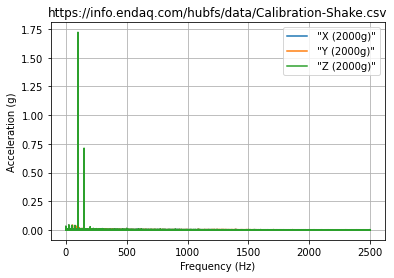

In [ ]:
fig, ax = plt.subplots() #create an empty plot

df_fft.plot(ax=ax) #use the dataframe to add plot data, tell it to add to the already created axes

ax.set(xlabel='Frequency (Hz)',
       ylabel='Acceleration (g)',
       title=filename)
ax.grid() #turn on gridlines

fig.savefig('fft.png')
plt.show()

### FFT from PSD
Here we can use the output of a PSD and convet it to a typical DFT. This has the benefit of allowing you to explicitely define the frequency bin width.

In [ ]:
df

,"""X (2000g)""","""Y (2000g)""","""Z (2000g)"""
Time,,,
0.004394,-0.122072,-0.122072,-0.061036
0.004594,-0.061036,0.488289,-0.366217
0.004794,0.183108,0.122072,-0.061036
0.004994,0.122072,-0.122072,-0.122072
0.005194,0.122072,0.122072,-0.244144
...,...,...,...
27.691064,-0.427253,-0.152590,-0.671397
27.691264,-0.122072,-0.335698,-0.305180
27.691464,-0.183108,-0.152590,-0.122072


In [ ]:
def get_fft_from_psd(df,bin_width):
  fs = len(df)/(df.index[-1]-df.index[0])
  f, psd = signal.welch(df.to_numpy(), 
                        fs=fs, 
                        nperseg=fs/bin_width,
                        window='hanning',
                        axis=0,
                        scaling = 'spectrum'
                        )

  df_psd = pd.DataFrame(psd**0.5,columns=df.columns)
  df_psd.columns
  df_psd['Frequency (Hz)'] = f
  return df_psd.set_index('Frequency (Hz)')

In [ ]:
df_fft_from_psd = get_fft_from_psd(df,.25)

fig = xp.line(df_fft_from_psd)
fig.update_layout(
    title="FFT from PSD",
    xaxis_title="Frequency (Hz)",
    yaxis_title="Acceleration (g)",
    #xaxis_type="log",
    #yaxis_type="log"
)
fig.show()
fig.write_html('fft_from_psd.html',full_html=False,include_plotlyjs='cdn')

## Moving Peak Frequency
Now we'll introduce a for loop to go through all the columns and find the moving peak frequency.

In [ ]:
def moving_frequency(df,steps):
  #df.index = np.linspace(df.index[0],df.index[-1],num=df.shape[0]) #resample to have uniform sampling
  d_t = (df.index[-1]-df.index[0])/(len(df.index)-1)
  fs = 1/d_t
  length = df.shape[0] #full length of time series data
  nperseg = length/5 #average 5 FFTs per segment
  n = int(length/steps) #the number of data points per step, we will not compute
  df_peak_freqs = pd.DataFrame(columns=df.columns)
  for i in range(0,length-n+1,n):
    df_sub = df.iloc[i:i+n]
    df_psd = get_psd(df_sub, nperseg/fs)
    time = (df_sub.index[-1]-df_sub.index[0])/2+df_sub.index[0]
    df_peak_freqs.loc[time] = df_psd.idxmax()
  return df_peak_freqs
    


In [ ]:
df_peak_freqs = moving_frequency(df,40) #get rolling peak frequency for 20 different steps

fig = xp.line(df_peak_freqs)
fig.update_layout(
    title="Rolling Peak Frequency",
    xaxis_title="Time (s)",
    yaxis_title="Peak Frequency (Hz)",
)
fig.show()
fig.write_html('rolling_peak_frequency.html',full_html=False,include_plotlyjs='cdn')